# Matrix Multiplication

Matrix multiplication operations are at the heart of many linear algebra algorithms, and efficient matrix multiplication is critical for many applications within the applied sciences.

To multiply two matrices, we can simply use 3 nested loops, assuming that matrices A, B, and C are all n-by-n and stored in one-dimensional column-major arrays:
```bash
for (int i = 0; i < n; i++)
    for (int j = 0; j < n; j++)
        for (int k = 0; k < n; k++)
            C[i+j*n] += A[i+k*n] * B[k+j*n];
```

the loops are ordered i, j, k. If we examine the innermost loop (k), we see that it moves through B with stride 1, A with stride n and C with stride 0. To compute the matrix multiplication correctly, the loop order doesn't matter. However, the order in which we choose to access the elements of the matrices can have a large impact on performance. Caches perform better (more cache hits, fewer cache misses) when memory accesses exhibit spatial and temporal locality. Optimizing a program's memory access patterns is essential to obtaining good performance from the memory hierarchy.

In the above code for matrix multiplication, note that we are striding across the entire A and B matrices to compute a single value of C. As such, we are constantly accessing new values from memory and obtain very little reuse of cached data! We can improve the amount of data reuse in the caches by implementing a technique called cache blocking. More formally, cache blocking is a technique that attempts to reduce the cache miss rate by improving the temporal and/or spatial locality of memory accesses. In the case of matrix transposition we consider performing the transposition one block at a time.

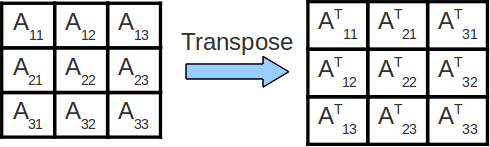

we transpose each block Aij of matrix A into its final location in the output matrix, one block at a time. With this scheme, we significantly reduce the magnitude of the working set in cache during the processing of any one block. This (if implemented correctly) will result in a substantial improvement in performance.

## Multiple ijk versions of Matrix Multiple

In [ ]:
%%writefile matrixmultiple.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <time.h>


/* We are including all 6 variants of the loop ordering
   as separate functions and then calling them using function pointers.
   The code defines six matrix multiplication functions: multMat1, multMat2, multMat3, multMat4, multMat5, and multMat6.
    Each function takes four arguments:
    n: The size of the matrices (assumed to be square matrices of dimension n x n).
    A: A pointer to the first matrix.
    B: A pointer to the second matrix.
    C: A pointer to the result matrix (where the product of A and B will be stored).
*/

void multMat1( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is ijk loop order. */
    for( i = 0; i < n; i++ )
        for( j = 0; j < n; j++ )
            for( k = 0; k < n; k++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat2( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is ikj loop order. */
    for( i = 0; i < n; i++ )
        for( k = 0; k < n; k++ )
            for( j = 0; j < n; j++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat3( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is jik loop order. */
    for( j = 0; j < n; j++ )
        for( i = 0; i < n; i++ )
            for( k = 0; k < n; k++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat4( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is jki loop order. */
    for( j = 0; j < n; j++ )
        for( k = 0; k < n; k++ )
            for( i = 0; i < n; i++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat5( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is kij loop order. */
    for( k = 0; k < n; k++ )
        for( i = 0; i < n; i++ )
            for( j = 0; j < n; j++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat6( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is kji loop order. */
    for( k = 0; k < n; k++ )
        for( j = 0; j < n; j++ )
            for( i = 0; i < n; i++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}


/* defaults to Part 1.  pass it any argument for Part 2. */
/* uses timing features from sys/time.h  */
int main( int argc, char **argv ) {
    int nmax = 1000,i,n;

    //The orderings array is an array of function pointers. It contains pointers to the six matrix multiplication functions.
    void (*orderings[])(int,float *,float *,float *) =
        {&multMat1,&multMat2,&multMat3,&multMat4,&multMat5,&multMat6};
    char *names[] = {"ijk","ikj","jik","jki","kij","kji"};

    float *A = (float *)malloc( nmax*nmax * sizeof(float));
    float *B = (float *)malloc( nmax*nmax * sizeof(float));
    float *C = (float *)malloc( nmax*nmax * sizeof(float));

    struct timeval start, end;

    if( argv[1] ) {
        printf("Running Part B...\n\n");

        /* fill matrices with random numbers */
        for( i = 0; i < nmax*nmax; i++ ) A[i] = drand48()*2-1;
        for( i = 0; i < nmax*nmax; i++ ) B[i] = drand48()*2-1;
        for( i = 0; i < nmax*nmax; i++ ) C[i] = drand48()*2-1;

        for( i = 0; i < 6; i++) {
            /* multiply matrices and measure the time */
            gettimeofday( &start, NULL );
            (*orderings[i])( nmax, A, B, C );
            gettimeofday( &end, NULL );

            /* convert time to Gflop/s */
            double seconds = (end.tv_sec - start.tv_sec) +
                1.0e-6 * (end.tv_usec - start.tv_usec);
            double Gflops = 2e-9*nmax*nmax*nmax/seconds;
            printf( "%s:\tn = %d, %.3f Gflop/s\n", names[i], nmax, Gflops );
        }
    } else {
        printf("Running Part A...\n\n");

        for( n = 10; n <= nmax; n = n<nmax && n+1+n/3>nmax ? nmax : n+1+n/3 ) {
            /* fill matrices with random numbers */
            for( i = 0; i < n*n; i++ ) A[i] = drand48()*2-1;
            for( i = 0; i < n*n; i++ ) B[i] = drand48()*2-1;
            for( i = 0; i < n*n; i++ ) C[i] = drand48()*2-1;

            /* multiply matrices and measure the time */
            gettimeofday( &start, NULL );
            multMat1( n, A, B, C );
            gettimeofday( &end, NULL );

            /* convert time to Gflop/s */
            double seconds = (end.tv_sec - start.tv_sec) +
                1.0e-6 * (end.tv_usec - start.tv_usec);
            double Gflops = 2e-9*n*n*n/seconds;
            printf( "n = %d, %.3f Gflop/s\n", n, Gflops );
        }
    }

    free( A );
    free( B );
    free( C );

    printf("\n\n");

    return 0;
}

Writing matrixmultiple.c


In [ ]:
!gcc matrixmultiple.c -O3 -o matrixmultiple

use the '-O3' flag to turn on compiler optimizations.

In [ ]:
!./matrixmultiple

Running Part A...

n = 10, 1.000 Gflop/s
n = 14, 1.372 Gflop/s
n = 19, 1.372 Gflop/s
n = 26, 1.528 Gflop/s
n = 35, 1.429 Gflop/s
n = 47, 1.538 Gflop/s
n = 63, 1.337 Gflop/s
n = 85, 1.285 Gflop/s
n = 114, 0.995 Gflop/s
n = 153, 1.256 Gflop/s
n = 205, 1.316 Gflop/s
n = 274, 1.278 Gflop/s
n = 366, 1.309 Gflop/s
n = 489, 1.276 Gflop/s
n = 653, 1.254 Gflop/s
n = 871, 1.219 Gflop/s
n = 1000, 1.148 Gflop/s




In [ ]:
!./matrixmultiple part2

Running Part B...

ijk:	n = 1000, 1.162 Gflop/s
ikj:	n = 1000, 0.081 Gflop/s
jik:	n = 1000, 1.079 Gflop/s
jki:	n = 1000, 8.637 Gflop/s
kij:	n = 1000, 0.082 Gflop/s
kji:	n = 1000, 5.642 Gflop/s




In [ ]:
!gcc matrixmultiple.c -o matrixmultiple2

In [ ]:
!./matrixmultiple2

Running Part A...

n = 10, 0.222 Gflop/s
n = 14, 0.134 Gflop/s
n = 19, 0.233 Gflop/s
n = 26, 0.244 Gflop/s
n = 35, 0.221 Gflop/s
n = 47, 0.231 Gflop/s
n = 63, 0.223 Gflop/s
n = 85, 0.215 Gflop/s
n = 114, 0.390 Gflop/s
n = 153, 0.399 Gflop/s
n = 205, 0.376 Gflop/s
n = 274, 0.371 Gflop/s
n = 366, 0.328 Gflop/s
n = 489, 0.335 Gflop/s
n = 653, 0.321 Gflop/s
n = 871, 0.254 Gflop/s
n = 1000, 0.302 Gflop/s




In [ ]:
!./matrixmultiple2 part2

Running Part B...

ijk:	n = 1000, 0.299 Gflop/s
ikj:	n = 1000, 0.078 Gflop/s
jik:	n = 1000, 0.199 Gflop/s
jki:	n = 1000, 0.326 Gflop/s
kij:	n = 1000, 0.079 Gflop/s
kji:	n = 1000, 0.391 Gflop/s




## Matrix Transpose

In [ ]:
%%writefile transpose.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <time.h>

void transpose( int n, int blocksize, int *dst, int *src ) {
    int i,j;
    /* TO DO: implement blocking (two more loops) */
    for(i = 0; i < n; i++)
        for(j = 0; j < n; j++)
            dst[j + i*n] = src[i + j*n];
}

int main( int argc, char **argv ) {
    int n = 2000,i,j;
    int blocksize = 20; /* to do: find a better block size */

    /* allocate an n*n block of integers for the matrices */
    int *A = (int*)malloc( n*n*sizeof(int) );
    int *B = (int*)malloc( n*n*sizeof(int) );

    /* initialize A,B to random integers */
    srand48( time( NULL ) );
    for( i = 0; i < n*n; i++ ) A[i] = lrand48( );
    for( i = 0; i < n*n; i++ ) B[i] = lrand48( );

    /* measure performance */
    struct timeval start, end;

    gettimeofday( &start, NULL );
    transpose( n, blocksize, B, A );
    gettimeofday( &end, NULL );

    double seconds = (end.tv_sec - start.tv_sec) +
        1.0e-6 * (end.tv_usec - start.tv_usec);
    printf( "%g milliseconds\n", seconds*1e3 );

    /* check correctness */
    for( i = 0; i < n; i++ )
        for( j = 0; j < n; j++ )
            if( B[j+i*n] != A[i+j*n] ) {
                printf("Error!!!! Transpose does not result in correct answer!!\n");
                exit( -1 );
            }

    /* release resources */
    free( A );
    free( B );
    return 0;
}


Writing transpose.c


In [ ]:
!gcc transpose.c -O3 -o transpose

In [ ]:
!./transpose

45.366 milliseconds


In [ ]:
!gcc transpose.c -o transpose2

In [ ]:
!./transpose2

51.413 milliseconds


## Using Makefile

In [ ]:
%%writefile Makefile
CC=gcc
LD=gcc
CFLAGS=-ggdb -Wall -pedantic -std=gnu99 -O3
LDFLAGS=

EX1_PROG=matrixmultiple

EX2_PROG=transpose

PROGS=$(EX1_PROG) $(EX2_PROG)

all: $(PROGS)

ex1: $(EX1_PROG)
	$(CC) -o $(EX1_PROG) $(CFLAGS) $(EX1_PROG).c
	./$(EX1_PROG)
	./$(EX1_PROG) 2

ex2: $(EX2_PROG)
	$(CC) -o $(EX2_PROG) $(CFLAGS) $(EX2_PROG).c
	./$(EX2_PROG)

clean:
	-rm -rf core *.o *~ "#"*"#" Makefile.bak $(PROGS) *.dSYM

Overwriting Makefile


In [ ]:
!make ex1

gcc -o matrixmultiple -ggdb -Wall -pedantic -std=gnu99 -O3 matrixmultiple.c
./matrixmultiple
Running Part A...

n = 10, 2.000 Gflop/s
n = 14, 2.744 Gflop/s
n = 19, 2.744 Gflop/s
n = 26, 2.511 Gflop/s
n = 35, 1.949 Gflop/s
n = 47, 1.648 Gflop/s
n = 63, 2.025 Gflop/s
n = 85, 1.742 Gflop/s
n = 114, 1.560 Gflop/s
n = 153, 1.523 Gflop/s
n = 205, 1.441 Gflop/s
n = 274, 1.251 Gflop/s
n = 366, 1.321 Gflop/s
n = 489, 1.295 Gflop/s
n = 653, 1.229 Gflop/s
n = 871, 1.256 Gflop/s
n = 1000, 1.237 Gflop/s


./matrixmultiple 2
Running Part B...

ijk:	n = 1000, 1.198 Gflop/s
ikj:	n = 1000, 0.076 Gflop/s
jik:	n = 1000, 0.750 Gflop/s
jki:	n = 1000, 8.121 Gflop/s
kij:	n = 1000, 0.077 Gflop/s
kji:	n = 1000, 5.505 Gflop/s




In [ ]:
!make ex2

gcc -o transpose -ggdb -Wall -pedantic -std=gnu99 -O3 transpose.c
./transpose
42.479 milliseconds


## Using Blocking

In [ ]:
%%writefile matrixmultipleblocked.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <time.h>
#include <math.h>


/* We are including all 6 variants of the loop ordering
   as separate functions and then calling them using function pointers.
   The code defines six matrix multiplication functions: multMat1, multMat2, multMat3, multMat4, multMat5, and multMat6.
    Each function takes four arguments:
    n: The size of the matrices (assumed to be square matrices of dimension n x n).
    A: A pointer to the first matrix.
    B: A pointer to the second matrix.
    C: A pointer to the result matrix (where the product of A and B will be stored).
*/

void multMat1( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is ijk loop order. */
    for( i = 0; i < n; i++ )
        for( j = 0; j < n; j++ )
            for( k = 0; k < n; k++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat2( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is ikj loop order. */
    for( i = 0; i < n; i++ )
        for( k = 0; k < n; k++ )
            for( j = 0; j < n; j++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat3( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is jik loop order. */
    for( j = 0; j < n; j++ )
        for( i = 0; i < n; i++ )
            for( k = 0; k < n; k++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat4( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is jki loop order. */
    for( j = 0; j < n; j++ )
        for( k = 0; k < n; k++ )
            for( i = 0; i < n; i++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat5( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is kij loop order. */
    for( k = 0; k < n; k++ )
        for( i = 0; i < n; i++ )
            for( j = 0; j < n; j++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat6( int n, float *A, float *B, float *C ) {
    int i,j,k;
    /* This is kji loop order. */
    for( k = 0; k < n; k++ )
        for( j = 0; j < n; j++ )
            for( i = 0; i < n; i++ )
                C[i+j*n] += A[i+k*n]*B[k+j*n];
}

void multMat1_blocked(int n, float *A, float *B, float *C, int block_size) {
    int i, j, k, ii, jj, kk;

    for (ii = 0; ii < n; ii += block_size) {
        for (jj = 0; jj < n; jj += block_size) {
            for (kk = 0; kk < n; kk += block_size) {
                // Perform matrix multiplication on blocks
                for (i = ii; i < ii + block_size; i++) {
                    for (j = jj; j < jj + block_size; j++) {
                        for (k = kk; k < kk + block_size; k++) {
                            C[i + j * n] += A[i + k * n] * B[k + j * n];
                            //C[i*n + j] += A[i*n + k] * B[k*n + j];
                        }
                    }
                }
            }
        }
    }
}


/* uses timing features from sys/time.h  */
int main( int argc, char **argv ) {
    int nmax = 1000,i,n;
    int block_size = 16;  // Choose an appropriate block size (e.g., 16)
    if (argc > 2)
      nmax = atoi(argv[1]);
      block_size = atoi(argv[2]);
    printf( "nmax = %d, block_size=%d\n", nmax, block_size );

    //The orderings array is an array of function pointers. It contains pointers to the six matrix multiplication functions.
    void (*orderings[])(int,float *,float *,float *) =
        {&multMat1,&multMat2,&multMat3,&multMat4,&multMat5,&multMat6};
    char *names[] = {"ijk","ikj","jik","jki","kij","kji"};

    float *A = (float *)malloc( nmax*nmax * sizeof(float));
    float *B = (float *)malloc( nmax*nmax * sizeof(float));
    float *C = (float *)malloc( nmax*nmax * sizeof(float));

    struct timeval start, end;

    /* fill matrices with random numbers */
    for( i = 0; i < nmax*nmax; i++ ) A[i] = drand48()*2-1;
    for( i = 0; i < nmax*nmax; i++ ) B[i] = drand48()*2-1;
    for( i = 0; i < nmax*nmax; i++ ) C[i] = 0;// drand48()*2-1;

    //test multimatrix multMat1_blocked
    gettimeofday( &start, NULL );
    // Call the modified matrix multiplication function
    multMat1_blocked(nmax, A, B, C, block_size);
    gettimeofday( &end, NULL );

    /* convert time to Gflop/s */
    double seconds = (end.tv_sec - start.tv_sec) +
        1.0e-6 * (end.tv_usec - start.tv_usec);
    double Gflops = 2e-9*nmax*nmax*nmax/seconds;
    printf( "%s:\tn = %d, %.3f Gflop/s\n", "multMat1_blocked", nmax, Gflops );

    // Verify correctness (compare with a straightforward implementation)
    for (int i = 0; i < nmax; i++) {
        for (int j = 0; j < nmax; j++) {
            float expected = 0.0;
            for (int k = 0; k < nmax; k++) {
                expected += A[i + k * nmax] * B[k + j * nmax];
                //C[i+j*n] += A[i+k*n]*B[k+j*n];
            }
            if (fabs(C[i + j * nmax] - expected) >= 1e-3) {
                printf("Error at C[%d, %d]\n", i, j);
                printf("Expected: %.6f, Actual: %.6f\n", expected, C[i + j * nmax]);
            }
        }
    }

    for( i = 0; i < 6; i++) {
        /* multiply matrices and measure the time */
        gettimeofday( &start, NULL );
        (*orderings[i])( nmax, A, B, C );
        gettimeofday( &end, NULL );

        /* convert time to Gflop/s */
        double seconds = (end.tv_sec - start.tv_sec) +
            1.0e-6 * (end.tv_usec - start.tv_usec);
        double Gflops = 2e-9*nmax*nmax*nmax/seconds;
        printf( "%s:\tn = %d, %.3f Gflop/s\n", names[i], nmax, Gflops );
    }

    free( A );
    free( B );
    free( C );

    printf("\n\n");

    return 0;
}

Overwriting matrixmultipleblocked.c


In [ ]:
!gcc matrixmultipleblocked.c -O3 -o matrixmultipleblocked

In [ ]:
!./matrixmultipleblocked 1000 100

nmax = 1000, block_size=100
multMat1_blocked:	n = 1000, 1.361 Gflop/s
ijk:	n = 1000, 1.208 Gflop/s
ikj:	n = 1000, 0.090 Gflop/s
jik:	n = 1000, 1.068 Gflop/s
jki:	n = 1000, 8.785 Gflop/s
kij:	n = 1000, 0.090 Gflop/s
kji:	n = 1000, 5.754 Gflop/s




In [ ]:
!./matrixmultipleblocked 1000 10

nmax = 1000, block_size=10
multMat1_blocked:	n = 1000, 1.390 Gflop/s
ijk:	n = 1000, 1.219 Gflop/s
ikj:	n = 1000, 0.098 Gflop/s
jik:	n = 1000, 0.741 Gflop/s
jki:	n = 1000, 5.835 Gflop/s
kij:	n = 1000, 0.098 Gflop/s
kji:	n = 1000, 5.539 Gflop/s




## MATMULT example

https://www.cs.cmu.edu/afs/cs/academic/class/15213-f15/www/code/12-cache-memories/matmult/

In [ ]:
%%writefile bmm.c
/* block matrix multiply (ijk and ikj permutations only) */
#include <stdio.h>
#include <stdlib.h>
#include "mm.h"
#include "fcycbmm.h"
#include "clock.h"

/* fcyc() should clear the cache */
#define CLEARCACHE 1

/* global arrays */
array ga, gb, gc;

/* check the result array for correctness */
void checkresult(array c, int n)
{
    int i, j;

    for (i = 0; i < n; i++)
	for (j = 0; j < n; j++)
	    if (c[i][j] != (double)n) {
		printf("Error: bad number (%f) in result matrix (%d,%d)\n",
		       c[i][j], i, j);
		exit(0);
	    }
}

/* Run f and return clocks per inner loop iteration */
double run(test_funct f, int n, int bsize)
{
    double cpi;

    cpi = fcyc(f, n, bsize, CLEARCACHE) / (n*n*n);
    checkresult(gc, n);
    return(cpi);
}

/* reset result array to zero */
void reset(array c, int n)
{
    int i,j;

    for (i = 0; i < n; i++) {
	for (j = 0; j < n; j++) {
	    c[i][j] = 0.0;
	}
    }
}

/* initialize input arrays to 1 */
void init(array a, array b, int n)
{
    int i,j;

    for (i = 0; i < n; i++) {
	for (j = 0; j < n; j++) {
	    a[i][j] = 1.0;
	    b[i][j] = 1.0;
	}
    }
}

/* print an array (debug) */
void printarray(array a, int n)
{
    int i, j;

    for (i = 0; i < n; i++) {
	for (j = 0; j < n; j++) {
	    printf("%5.1f ", a[i][j]);
	}
	printf("\n");
    }
}

/***************************************************
 * Two different versions of blocked matrix multiply
 ***************************************************/
/* $begin bmm-ijk */
void bijk(array A, array B, array C, int n, int bsize)
{
    int i, j, k, kk, jj;
    double sum;
    int en = bsize * (n/bsize); /* Amount that fits evenly into blocks */

    for (i = 0; i < n; i++)
	for (j = 0; j < n; j++)
	    C[i][j] = 0.0;

    for (kk = 0; kk < en; kk += bsize) {
	for (jj = 0; jj < en; jj += bsize) {
	    for (i = 0; i < n; i++) {
		for (j = jj; j < jj + bsize; j++) {
		    sum = C[i][j];
		    for (k = kk; k < kk + bsize; k++) {
			sum += A[i][k]*B[k][j];
		    }
		    C[i][j] = sum;
		}
	    }
	}
	/* $end bmm-ijk */
	/* Now finish off rest of j values  (not shown in textbook) */
	for (i = 0; i < n; i++) {
	    for (j = en; j < n; j++) {
		sum = C[i][j];
		for (k = kk; k < kk + bsize; k++) {
		    sum += A[i][k]*B[k][j];
		}
		C[i][j] = sum;
	    }
	}
	/* $begin bmm-ijk */
    }
    /* $end bmm-ijk */
    /* Now finish remaining k values (not shown in textbook) */
    for (jj = 0; jj < en; jj += bsize) {
	for (i = 0; i < n; i++) {
	    for (j = jj; j < jj + bsize; j++) {
		sum = C[i][j];
		for (k = en; k < n; k++) {
		    sum += A[i][k]*B[k][j];
		}
		C[i][j] = sum;
	    }
	}
    }

    /* Now finish off rest of j values (not shown in textbook) */
    for (i = 0; i < n; i++) {
	for (j = en; j < n; j++) {
	    sum = C[i][j];
	    for (k = en; k < n; k++) {
		sum += A[i][k]*B[k][j];
	    }
	    C[i][j] = sum;
	}
    }
    /* $begin bmm-ijk */
}
/* $end bmm-ijk */

void bikj(array A, array B, array C, int n, int bsize)
{
    int i, j, k;
    int kk, jj;
    double r;

    int en = bsize*(n/bsize); /* Number of elements within normal blocks */
    for (i = 0; i < n; i++)
	for (j = 0; j < n; j++)
	    C[i][j] = 0.0;
    /* Do blocks along k */
    for (kk = 0; kk < en; kk += bsize) {
	for (jj = 0; jj < en; jj += bsize) {
	    for (i = 0; i < n; i++) {
		for (k = kk; k < kk + bsize; k++) {
		    r = A[i][k];
		    for (j = jj; j < jj + bsize; j++) {
			C[i][j] += r*B[k][j];
		    }
		}
	    }
	}

	/* Now finish remaining j values */
	for (i = 0; i < n; i++) {
	    for (k = kk; k < kk + bsize; k++) {
		r = A[i][k];
		for (j = en; j < n; j++) {
		    C[i][j] += r*B[k][j];
		}
	    }
	}
    }

    /* Now finish remaining values of k */
    for (jj = 0; jj < en; jj += bsize) {
	for (i = 0; i < n; i++) {
	    for (k = en; k < n; k++) {
		r = A[i][k];
		for (j = jj; j < jj + bsize; j++) {
		    C[i][j] += r*B[k][j];
		}
	    }
	}
    }

    /* Now finish remaining j values */
    for (i = 0; i<n; i++) {
	for (k = en; k < n; k++) {
	    r = A[i][k];
	    for (j = en; j < n; j++) {
		C[i][j] += r*B[k][j];
	    }
	}
    }
}

/* Run different versions of blocked matrix multiply
   and return display cycles per inner loop iteration. */

int main(int argc, char **argv)
{
    int n, bsize;

    init(ga, gb, MAXN);

    printf("blocked mm cycles/iteration (for varying matrix sizes)\n");
    printf("%3s%3s%7s%7s\n", "n", "b", "ijk", "ikj");

    /* See the effect of varying sizes */
    bsize = INCN;
    for (n = MINN; n <= MAXN; n += bsize) {
	printf("%3d %3d ", n, bsize);
	printf("%5.2f ", run(bijk, n, bsize));
	fflush(stdout);
	printf("%5.2f ", run(bikj, n, bsize));
	printf("\n");
    }
    printf("\n");

    /* Now see effect of varying block sizes */
    printf("blocked mm cycles/iteration (for varying block sizes)\n");
    printf("%3s%3s%7s%7s\n", "n", "b", "ijk", "ikj");

    n = MAXN;
    for (bsize = INCN; bsize <= n; bsize += INCN) {
	printf("%3d %3d ", n, bsize);
	printf("%5.2f ", run(bijk, n, bsize));
	fflush(stdout);
	printf("%5.2f ", run(bikj, n, bsize));
	printf("\n");
    }

    exit(0);
}


Writing bmm.c


In [ ]:
!make all

gcc -O4 -Wall -mavx2 -o mm mm.c clock.c fcycmm.c
gcc -O4 -Wall -mavx2 -o bmm bmm.c clock.c fcycbmm.c


In [ ]:
!ls

bmm	 fcycbmm.c  Makefile		   matrixmultipleblocked.c  mm.h	 transpose.c
bmm.c	 fcycbmm.h  matrixmultiple	   matrixmultiple.c	    sample_data
clock.c  fcycmm.c   matrixmultiple2	   mm			    transpose
clock.h  fcycmm.h   matrixmultipleblocked  mm.c			    transpose2


In [ ]:
!./mm

matmult cycles/loop iteration
  n   jki   kji   ijk   jik   kij   ikj
 50  2.77  2.80  2.87  3.06  0.95  0.62 
100  2.42  2.43  2.56  2.48  0.60  0.60 
150  2.41  2.43  2.73  2.77  0.62  0.63 
200  2.50  2.40  2.94  2.94  0.64  0.63 
250  2.58  2.55  3.00  3.15  0.72  0.66 
300  3.19  3.11  3.55  3.71  1.21  1.08 
350  3.89  3.76  3.29  3.46  0.93  0.80 
400  4.10  3.96  3.33  3.57  1.04  0.84 
450  4.10  3.97  3.37  3.54  1.05  0.85 
500  4.13  4.02  3.39  3.57  1.12  0.84 
550  4.19  4.14  3.40  3.52  1.20  0.85 
^C


In [ ]:
!./bmm

blocked mm cycles/iteration (for varying matrix sizes)
  n  b    ijk    ikj
 50  50  2.17  0.65 
100  50  2.19  0.66 
150  50  2.15  0.67 
200  50  2.20  0.67 
250  50  2.25  0.70 
300  50  2.24  0.70 
350  50  2.26  0.70 
400  50  2.28  0.74 
450  50  2.27  0.74 
500  50  2.38  0.83 
550  50  2.34  0.82 
600  50  2.41  0.81 
650  50  2.35  0.80 
700  50  2.35  0.86 

blocked mm cycles/iteration (for varying block sizes)
  n  b    ijk    ikj
700  50  2.35  0.81 
700 100  2.77  0.76 
700 150  2.91  0.76 
700 200  2.94  0.73 
700 250  3.14  0.73 
700 300  3.18  0.77 
700 350  3.35  0.90 
700 400  3.37  0.87 
700 450  3.37  0.86 
700 500  3.38  0.84 
700 550  3.30  0.83 
700 600  3.35  0.86 
700 650  3.43  0.92 
700 700  3.68  1.00 


# BLAS version

## GSL CBLAS

Using GSL (GNU Scientific Library) with CBLAS

In [ ]:
!sudo apt-get install libgsl-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgsl27 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libgsl-dev libgsl27 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,351 kB of archives.
After this operation, 10.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgslcblas0 amd64 2.7.1+dfsg-3 [94.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl27 amd64 2.7.1+dfsg-3 [1,000 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl-dev amd64 2.7.1+dfsg-3 [1,257 kB]
Fetched 2,351 kB in 0s (6,573 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/

https://netlib.org/lapack/explore-html/db/d66/cblas__sgemm_8c_source.html

```bash
func cblas_sgemm(
    _ __Order: CBLAS_ORDER,
    _ __TransA: CBLAS_TRANSPOSE,
    _ __TransB: CBLAS_TRANSPOSE,
    _ __M: Int32,
    _ __N: Int32,
    _ __K: Int32,
    _ __alpha: Float,
    _ __A: UnsafePointer<Float>!,
    _ __lda: Int32,
    _ __B: UnsafePointer<Float>!,
    _ __ldb: Int32,
    _ __beta: Float,
    _ __C: UnsafeMutablePointer<Float>!,
    _ __ldc: Int32
)
```
https://developer.apple.com/documentation/accelerate/1513264-cblas_sgemm
Order
Specifies row-major (C) or column-major (Fortran) data ordering.

TransA
Specifies whether to transpose matrix A.

TransB
Specifies whether to transpose matrix B.

M
Number of rows in matrices A and C.

N
Number of columns in matrices B and C.

K
Number of columns in matrix A; number of rows in matrix B.

alpha
Scaling factor for the product of matrices A and B.

A
Matrix A.

lda
The size of the first dimension of matrix A; if you are passing a matrix A[m][n], the value should be m.

B
Matrix B.

ldb
The size of the first dimension of matrix B; if you are passing a matrix B[m][n], the value should be m.

beta
Scaling factor for matrix C.

C
Matrix C.

ldc
The size of the first dimension of matrix C; if you are passing a matrix C[m][n], the value should be m.

This function multiplies A * B and multiplies the resulting matrix by alpha. It then multiplies matrix C by beta. It stores the sum of these two products in matrix C.

Thus, it calculates either

C←αAB + βC

or

C←αBA + βC

with optional use of transposed forms of A, B, or both.

In [ ]:
%%writefile cblas_example.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <time.h>
#include <gsl/gsl_cblas.h>
#include <math.h>

int main(int argc, char **argv) {
    int n = 2;  // Matrix size
    int i;
    if (argc > 1)
      n = atoi(argv[1]);
    printf( "n = %d\n", n);

    float alpha = 1.0;
    float beta = 0.0;

    //float A[] = {1, 2, 3, 4, 5, 6};
    //float B[] = {1, 2, 3, 3, 3, 5};
    //float C[] = {0.0, 0.0, 0.0, 0.0};

    float *A = (float *)malloc( n*n * sizeof(float));
    float *B = (float *)malloc( n*n * sizeof(float));
    float *C = (float *)malloc( n*n * sizeof(float));

    /* fill matrices with random numbers */
    for( i = 0; i < n*n; i++ ) A[i] = drand48()*2-1;
    for( i = 0; i < n*n; i++ ) B[i] = drand48()*2-1;
    for( i = 0; i < n*n; i++ ) C[i] = 0;// drand48()*2-1;

    /* measure performance */
    struct timeval start, end;

    gettimeofday( &start, NULL );
    // Compute C = A * B
    cblas_sgemm(CblasRowMajor, CblasNoTrans, CblasNoTrans, n, n, n, alpha, A, n, B, n, beta, C, n);
    gettimeofday( &end, NULL );

    double seconds = (end.tv_sec - start.tv_sec) +
        1.0e-6 * (end.tv_usec - start.tv_usec);
    printf( "%g milliseconds\n", seconds*1e3 );

    /* convert time to Gflop/s */
    double Gflops = 2e-9*n*n*n/seconds;
    printf( "%s:\tn = %d, %.3f Gflop/s\n", "Speed", n, Gflops);

    // Verify correctness (compare with a straightforward implementation)
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            float expected = 0.0;
            for (int k = 0; k < n; k++) {
                expected += A[i*n + k] * B[k*n + j];
                //C[i+j*n] += A[i+k*n]*B[k+j*n];
            }
            if (fabs(C[i*n + j] - expected) >= 1e-3) {
                printf("Error at C[%d, %d]\n", i, j);
                printf("Expected: %.6f, Actual: %.6f\n", expected, C[i + j * n]);
            }
        }
    }

    // Print the result matrix
    printf("[%.2f, %.2f]\n", C[0], C[1]);
    printf("[%.2f, %.2f]\n", C[2], C[3]);

    return 0;
}


Overwriting cblas_example.c


In [ ]:
!gcc -o cblas_example cblas_example.c -lgsl -lgslcblas -lm

In [ ]:
!ls

cblas_example  cblas_example.c	sample_data


In [ ]:
!./cblas_example 1000

n = 1000
1500.53 milliseconds
Speed:	n = 1000, 1.333 Gflop/s
[-7.10, -0.55]
[-5.90, -1.15]


In [ ]:
!sudo apt -y install intel-mkl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
intel-mkl is already the newest version (2020.4.304-2ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
%%writefile mkl_example.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <time.h>
//#include <gsl/gsl_cblas.h>
#include <mkl.h>
#include <math.h>

int main(int argc, char **argv) {
    int n = 2;  // Matrix size
    int i;
    if (argc > 1)
      n = atoi(argv[1]);
    printf( "n = %d\n", n);

    float alpha = 1.0;
    float beta = 0.0;

    //float A[] = {1, 2, 3, 4, 5, 6};
    //float B[] = {1, 2, 3, 3, 3, 5};
    //float C[] = {0.0, 0.0, 0.0, 0.0};

    float *A = (float *)malloc( n*n * sizeof(float));
    float *B = (float *)malloc( n*n * sizeof(float));
    float *C = (float *)malloc( n*n * sizeof(float));

    /* fill matrices with random numbers */
    for( i = 0; i < n*n; i++ ) A[i] = drand48()*2-1;
    for( i = 0; i < n*n; i++ ) B[i] = drand48()*2-1;
    for( i = 0; i < n*n; i++ ) C[i] = 0;// drand48()*2-1;

    /* measure performance */
    struct timeval start, end;

    gettimeofday( &start, NULL );
    // Compute C = A * B
    cblas_sgemm(CblasRowMajor, CblasNoTrans, CblasNoTrans, n, n, n, alpha, A, n, B, n, beta, C, n);
    gettimeofday( &end, NULL );

    double seconds = (end.tv_sec - start.tv_sec) +
        1.0e-6 * (end.tv_usec - start.tv_usec);
    printf( "%g milliseconds\n", seconds*1e3 );

    /* convert time to Gflop/s */
    double Gflops = 2e-9*n*n*n/seconds;
    printf( "%s:\tn = %d, %.3f Gflop/s\n", "Speed", n, Gflops);

    // Verify correctness (compare with a straightforward implementation)
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            float expected = 0.0;
            for (int k = 0; k < n; k++) {
                expected += A[i*n + k] * B[k*n + j];
                //C[i+j*n] += A[i+k*n]*B[k+j*n];
            }
            if (fabs(C[i*n + j] - expected) >= 1e-3) {
                printf("Error at C[%d, %d]\n", i, j);
                printf("Expected: %.6f, Actual: %.6f\n", expected, C[i + j * n]);
            }
        }
    }

    // Print the result matrix
    printf("[%.2f, %.2f]\n", C[0], C[1]);
    printf("[%.2f, %.2f]\n", C[2], C[3]);

    return 0;
}


Writing mkl_example.c


In [ ]:
!icc --version

/bin/bash: line 1: icc: command not found


In [ ]:
!icc -o mkl_example mkl_example.c -lmkl_intel_lp64 -lmkl_sequential -lmkl_core -lpthread -lm

/bin/bash: line 1: icc: command not found


In [ ]:
!ls /opt/

google	nvidia


## Intel OneAPI MKL

https://www.intel.com/content/www/us/en/developer/tools/oneapi/onemkl-download.html?operatingsystem=linux&distributions=aptpackagemanager

Get Started with Intel® oneAPI Math Kernel Library: https://www.intel.com/content/www/us/en/docs/onemkl/get-started-guide/2024-1/overview.html

Intel® oneAPI Math Kernel Library - C: https://www.intel.com/content/www/us/en/docs/onemkl/developer-reference-c/2024-1/overview.html

In [ ]:
!sudo apt install -y gpg-agent wget

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1).
gpg-agent is already the newest version (2.2.27-3ubuntu2.1).
gpg-agent set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!wget -O- https://apt.repos.intel.com/intel-gpg-keys/GPG-PUB-KEY-INTEL-SW-PRODUCTS.PUB | gpg --dearmor | sudo tee /usr/share/keyrings/oneapi-archive-keyring.gpg > /dev/null

--2024-04-29 17:21:27--  https://apt.repos.intel.com/intel-gpg-keys/GPG-PUB-KEY-INTEL-SW-PRODUCTS.PUB
Resolving apt.repos.intel.com (apt.repos.intel.com)... 23.33.34.115, 2600:1408:5400:49b::a87, 2600:1408:5400:4a3::a87
Connecting to apt.repos.intel.com (apt.repos.intel.com)|23.33.34.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4738 (4.6K) [application/vnd.exstream-package]
Saving to: ‘STDOUT’

-                   100%[===================>]   4.63K  --.-KB/s    in 0s      

2024-04-29 17:21:28 (2.40 GB/s) - written to stdout [4738/4738]



In [ ]:
!echo "deb [signed-by=/usr/share/keyrings/oneapi-archive-keyring.gpg] https://apt.repos.intel.com/oneapi all main" | sudo tee /etc/apt/sources.list.d/oneAPI.list

deb [signed-by=/usr/share/keyrings/oneapi-archive-keyring.gpg] https://apt.repos.intel.com/oneapi all main


In [ ]:
!sudo apt update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://apt.repos.intel.com/oneapi all InRelease [5,676 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,756 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [52.9 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,077 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:13 https://ppa.launchpadcontent.net/graphics-d

In [ ]:
!sudo apt install intel-oneapi-mkl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  intel-oneapi-common-licensing-2024.1 intel-oneapi-common-oneapi-vars-2024.1
  intel-oneapi-common-vars intel-oneapi-compiler-dpcpp-cpp-runtime-2024.1
  intel-oneapi-compiler-shared-runtime-2024.1 intel-oneapi-mkl-2024.1
  intel-oneapi-mkl-classic-2024.1 intel-oneapi-mkl-cluster-2024.1
  intel-oneapi-mkl-core-2024.1 intel-oneapi-mkl-core-common-2024.1
  intel-oneapi-mkl-sycl-2024.1 intel-oneapi-mkl-sycl-blas-2024.1
  intel-oneapi-mkl-sycl-data-fitting-2024.1 intel-oneapi-mkl-sycl-dft-2024.1
  intel-oneapi-mkl-sycl-lapack-2024.1 intel-oneapi-mkl-sycl-rng-2024.1
  intel-oneapi-mkl-sycl-sparse-2024.1 intel-oneapi-mkl-sycl-stats-2024.1
  intel-oneapi-mkl-sycl-vm-2024.1 intel-oneapi-openmp-2024.1
  intel-oneapi-openmp-common-2024.1 intel-oneapi-tbb-2021.12
  intel-oneapi-tbb-common-2021.12 intel-oneapi-tcm-1.0
The following NEW packages will 

For installation with header files, install the oneMKL development package using the following command:
sudo apt install intel-oneapi-mkl-devel

In [ ]:
!sudo apt install intel-oneapi-mkl-devel

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  intel-oneapi-mkl-classic-devel-2024.1
  intel-oneapi-mkl-classic-include-2024.1
  intel-oneapi-mkl-classic-include-common-2024.1
  intel-oneapi-mkl-cluster-devel-2024.1
  intel-oneapi-mkl-cluster-devel-common-2024.1
  intel-oneapi-mkl-core-devel-2024.1 intel-oneapi-mkl-core-devel-common-2024.1
  intel-oneapi-mkl-devel-2024.1 intel-oneapi-mkl-sycl-devel-2024.1
  intel-oneapi-mkl-sycl-devel-common-2024.1
  intel-oneapi-mkl-sycl-include-2024.1
The following NEW packages will be installed:
  intel-oneapi-mkl-classic-devel-2024.1
  intel-oneapi-mkl-classic-include-2024.1
  intel-oneapi-mkl-classic-include-common-2024.1
  intel-oneapi-mkl-cluster-devel-2024.1
  intel-oneapi-mkl-cluster-devel-common-2024.1
  intel-oneapi-mkl-core-devel-2024.1 intel-oneapi-mkl-core-devel-common-2024.1
  intel-oneapi-mkl-devel intel-oneapi-mkl-devel-2024.1
  int

In [ ]:
!ls /opt/intel/oneapi

common	compiler  licensing  mkl  modulefiles-setup.sh	setvars.sh  support.txt  tbb  tcm


In [ ]:
!ls /opt/intel/oneapi/compiler/latest/bin/compiler

llvm-ar   llvm-foreach	llvm-ml  llvm-objcopy	llvm-profgen  llvm-spirv
llvm-cov  llvm-link	llvm-nm  llvm-profdata	llvm-ranlib   llvm-symbolizer


In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: compiler -- latest
:: mkl -- latest
:: tbb -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!ls /opt/intel/oneapi/mkl/latest/env

vars.sh


In [ ]:
!source /opt/intel/oneapi/mkl/latest/env/vars.sh

In [ ]:
!env | grep SETVARS_COMPLETED

In [ ]:
!ls /opt/intel/oneapi/mkl/latest

bin  env  etc  include	lib  share


Intel linker advisor: https://www.intel.com/content/www/us/en/developer/tools/oneapi/onemkl-link-line-advisor.html#gs.8nzptm

In [ ]:
!gcc -o mkl_example mkl_example.c -I/opt/intel/oneapi/mkl/latest/include -L/opt/intel/oneapi/mkl/latest/lib/intel64 -lmkl_intel_lp64 -lmkl_intel_thread -lmkl_core -liomp5 -lpthread -lm -ldl

`-I$MKLROOT/include`:
Specifies an additional include directory where the compiler should search for header files.
$MKLROOT/include points to the directory containing Intel MKL header files (such as mkl.h).

`-L$MKLROOT/lib/intel64`:
Specifies an additional library directory where the linker should search for libraries.
$MKLROOT/lib/intel64 points to the directory containing Intel MKL libraries.

`-lmkl_intel_lp64 -lmkl_intel_thread -lmkl_core -liomp5`:
These options link your program with specific Intel MKL libraries:
libmkl_intel_lp64: Intel MKL LP64 interface (64-bit integers).
libmkl_intel_thread: Intel MKL threading support.
libmkl_core: Intel MKL core functionality.
libiomp5: Intel OpenMP runtime library.

`-lpthread -lm -ldl`:
These options link your program with standard system libraries:
-lpthread: Links with the POSIX threads library (for multithreading support).
-lm: Links with the math library (for mathematical functions).
-ldl: Links with the dynamic loading library (for dynamic loading of shared libraries

In [ ]:
!./mkl_example 1000

n = 1000
52.09 milliseconds
Speed:	n = 1000, 38.395 Gflop/s
[-7.10, -0.55]
[-5.90, -1.15]


##Intel oneAPI DPC++/C++ Compiler in OneAPI basekit

The Intel® oneAPI DPC++/C++ Compiler is available as part of the Intel® oneAPI Base Toolkit, Intel® HPC Toolkit, Intel® oneAPI IoT Toolkit, or as a standalone compiler.

In [ ]:
!sudo apt install intel-basekit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  intel-basekit-env-2024.1 intel-basekit-getting-started-2024.1
  intel-oneapi-advisor intel-oneapi-ccl-2021.12 intel-oneapi-ccl-devel
  intel-oneapi-ccl-devel-2021.12 intel-oneapi-common-licensing
  intel-oneapi-common-oneapi-vars intel-oneapi-compiler-cpp-eclipse-cfg-2024.1
  intel-oneapi-compiler-dpcpp-cpp intel-oneapi-compiler-dpcpp-cpp-2024.1
  intel-oneapi-compiler-dpcpp-cpp-common-2024.1
  intel-oneapi-compiler-dpcpp-eclipse-cfg-2024.1
  intel-oneapi-compiler-shared-2024.1
  intel-oneapi-compiler-shared-common-2024.1 intel-oneapi-dal-2024.2
  intel-oneapi-dal-common-2024.2 intel-oneapi-dal-common-devel-2024.2
  intel-oneapi-dal-devel intel-oneapi-dal-devel-2024.2
  intel-oneapi-dev-utilities intel-oneapi-dev-utilities-2024.1
  intel-oneapi-dev-utilities-eclipse-cfg-2024.1
  intel-oneapi-diagnostics-utility intel-oneapi-diagnostics-

In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icpx --version

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
Intel(R) oneAPI DPC++/C++ Compiler 2024.1.0 (2024.1.0.20240308)
Target: x86_64-unknown-linux-gnu
Thread model: posix
InstalledDir: /opt/intel/oneapi/compiler/2024.1/bin/compiler
Configuration file: /opt/intel/oneapi/compiler/2024.1/bin/compiler/../icpx.cfg


Intel® oneAPI DPC++/C++ Compiler: https://www.intel.com/content/www/us/en/developer/tools/oneapi/dpc-compiler.html#gs.8o0r4h

In [ ]:
%%writefile hello-world.cpp

#include <iostream>
int main()
{
    std::cout << "Welcome To oneapi\n";
    return 0;
}

Writing hello-world.cpp


In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icpx hello-world.cpp -o hello-world

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!ls

a.out	       cblas_example.c	hello-world.cpp  mkl_example.c
cblas_example  hello-world	mkl_example	 sample_data


In [ ]:
!./hello-world

Welcome To oneapi


In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icx -o mkl_exampleicc mkl_example.c -lmkl_intel_lp64 -lmkl_sequential -lmkl_core -lpthread -lm

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


`-lmkl_intel_lp64 -lmkl_sequential -lmkl_core`:
These options link your program with specific Intel Math Kernel Library (MKL) libraries:
libmkl_intel_lp64: Intel MKL LP64 interface (64-bit integers).
libmkl_sequential: Intel MKL sequential threading support.
libmkl_core: Intel MKL core functionality.

`-lpthread`:
Links with the POSIX threads library (for multithreading support).

`-lm`:
Links with the math library (for mathematical functions).

In [ ]:
!ls

a.out	       cblas_example.c	hello-world.cpp  mkl_example.c	 sample_data
cblas_example  hello-world	mkl_example	 mkl_exampleicc


In [ ]:
!./mkl_exampleicc 1000

n = 1000
45.153 milliseconds
Speed:	n = 1000, 44.294 Gflop/s
[-7.10, -0.55]
[-5.90, -1.15]


## oneMKL optimized matrix multiplication

use the oneMKL optimized matrix multiplication routines, ref: https://github.com/oneapi-src/oneAPI-samples/tree/master/Libraries/oneMKL/matrix_mul_mkl

In [ ]:
%%writefile utilities.hpp
#include <sycl/sycl.hpp>
#include <algorithm>

template <typename T> const char *type_string()     { return "unknown type"; }
template <> const char *type_string<sycl::half>()   { return "half precision"; }
template <> const char *type_string<float>()        { return "single precision"; }
template <> const char *type_string<double>()       { return "double precision"; }

/* Choose inter-column padding for optimal performance */
template <typename T>
int nice_ld(int x)
{
    x = std::max(x, 1);
    x *= sizeof(T);
    x = (x + 511) & ~511;
    x += 256;
    x /= sizeof(T);
    return x;
}

/* Random number generation helpers */
template <typename T>
void generate_random_data(size_t elems, T *v)
{
#pragma omp parallel for
    for (size_t i = 0; i < elems; i++)
        v[i] = double(std::rand()) / RAND_MAX;
}

template <typename T>
void replicate_data(sycl::queue &Q, T *dst, size_t dst_elems, const T *src, size_t src_elems)
{
    while (dst_elems > 0) {
        auto copy_elems = std::min(dst_elems, src_elems);
        Q.copy(src,  dst, copy_elems);
        dst += copy_elems;
        dst_elems -= copy_elems;
    }
    Q.wait();
}

Writing utilities.hpp


In [ ]:
%%writefile matrix_mul_mkl.cpp
// Contents:
//     A simple matrix multiplication benchmark, using the oneAPI Math Kernel
//     Library (oneMKL).
//

#include <sycl/sycl.hpp>
#include <oneapi/mkl.hpp>
#include <chrono>
#include <cstdlib>
#include <iomanip>
#include <iostream>
#include <string>

#include "utilities.hpp"

using namespace sycl;

template <typename T>
void test(queue &Q, int M, int N, int K)
{
    std::cout << "\nBenchmarking (" << M << " x " << K << ") x (" << K << " x " << N << ") matrix multiplication, " << type_string<T>() << std::endl;;

    std::cout << " -> Initializing data...\n";

    /* Allocate A/B/C matrices */
    int lda = nice_ld<T>(M);
    int ldb = nice_ld<T>(K);
    int ldc = nice_ld<T>(M);

    auto A = malloc_device<T>(lda * K, Q);
    auto B = malloc_device<T>(ldb * N, Q);
    auto C = malloc_device<T>(ldc * N, Q);

    /* Fill A/B with random data */
    constexpr int rd_size = 1048576;
    auto random_data = malloc_host<T>(rd_size, Q);
    generate_random_data(rd_size, random_data);

    replicate_data(Q, A, lda * K, random_data, rd_size);
    replicate_data(Q, B, ldb * N, random_data, rd_size);

    /* Measure time for a given number of GEMM calls */
    auto time_gemms = [=, &Q](int runs) -> double {
        using namespace oneapi::mkl;
        using namespace std::chrono;
        auto start = steady_clock::now();
        for (int i = 0; i < runs; i++)
            blas::gemm(Q, transpose::N, transpose::N, M, N, K, 1, A, lda, B, ldb, 0, C, ldc);
        Q.wait_and_throw();
        auto end = steady_clock::now();
        return duration<double>(end - start).count();
    };

    /* Do a warmup call to initialize MKL and ensure kernels are JIT'ed if needed */
    std::cout << " -> Warmup...\n";
    (void) time_gemms(1);

    /* Time one GEMM call, and estimate how many calls will be required to keep the
     * GPU busy for 1s. */
    auto tare = time_gemms(1);
    int ncalls = std::max(4, std::min(1000, int(1. / tare)));

    /* Time that many GEMMs, subtracting the first call time to remove host overhead.
     * This gives a better idea of device performance. */
    std::cout << " -> Timing...\n";
    auto time = time_gemms(ncalls + 1) - tare;
    auto avg = time / ncalls;

    /* Calculate and display performance */
    auto op_count = double(M) * double(N) * double(K) * 2;
    auto flops = op_count / avg;

    flops *= 1e-9;
    char unit = 'G';
    if (flops >= 1000.) {
        flops *= 1e-3;
        unit = 'T';
    }
    if (flops >= 1000.) {
        flops *= 1e-3;
        unit = 'P';
    }

    std::cout << "\nAverage performance: " << flops << unit << 'F' << std::endl;

    /* Free data */
    free(A, Q);
    free(B, Q);
    free(C, Q);
    free(random_data, Q);
}

void usage(const char *pname)
{
    std::cerr << "Usage:\n"
              << "  " << pname << " [type] N           benchmark (NxN) x (NxN) square matrix multiplication (default: N = 4096)\n"
              << "  " << pname << " [type] M N K       benchmark (MxK) x (KxN) square matrix multiplication\n"
              << "\n"
              << "The optional [type] selects the data type:\n"
              << "   double    [default]\n"
              << "   single\n"
              << "   half\n"
              << "\n"
              << "This benchmark uses the default DPC++ device, which can be controlled using\n"
              << "  the ONEAPI_DEVICE_SELECTOR environment variable\n";
    std::exit(1);
}

int main(int argc, char **argv)
{
    auto pname = argv[0];
    int M = 4096, N = 4096, K = 4096;
    std::string type = "double";

    if (argc <= 1)
        usage(pname);

    if (argc > 1 && std::isalpha(argv[1][0])) {
        type = argv[1];
        argc--; argv++;
    }

    if (argc > 1) M = N = K = std::atoi(argv[1]);

    if (argc > 3) {
        N = std::atoi(argv[2]);
        K = std::atoi(argv[3]);
    }

    if (M <= 0 || N <= 0 || K <= 0)
        usage(pname);

    queue Q;

    std::cout << "oneMKL DPC++ GEMM benchmark\n"
              << "---------------------------\n"
              << "Device:                  " << Q.get_device().get_info<info::device::name>()                          << std::endl
              << "Core/EU count:           " << Q.get_device().get_info<info::device::max_compute_units>()             << std::endl
              << "Maximum clock frequency: " << Q.get_device().get_info<info::device::max_clock_frequency>() << " MHz" << std::endl;

    if (type == "double")
        test<double>(Q, M, N, K);
    else if (type == "single" || type == "float")
        test<float>(Q, M, N, K);
    else if (type == "half")
        test<half>(Q, M, N, K);
    else
        usage(pname);
}

Overwriting matrix_mul_mkl.cpp


In [ ]:
%%writefile dpc_common.hpp
#ifndef _DP_HPP
#define _DP_HPP

#include <stdlib.h>
#include <exception>

#include <sycl/sycl.hpp>

namespace dpc_common {
// This exception handler will catch async exceptions
static auto exception_handler = [](sycl::exception_list eList) {
  for (std::exception_ptr const &e : eList) {
    try {
      std::rethrow_exception(e);
    } catch (std::exception const &e) {
#if _DEBUG
      std::cout << "Failure" << std::endl;
#endif
      std::terminate();
    }
  }
};

// The TimeInterval is a simple RAII class.
// Construct the timer at the point you want to start timing.
// Use the Elapsed() method to return time since construction.

class TimeInterval {
 public:
  TimeInterval() : start_(std::chrono::steady_clock::now()) {}

  double Elapsed() {
    auto now = std::chrono::steady_clock::now();
    return std::chrono::duration_cast<Duration>(now - start_).count();
  }

 private:
  using Duration = std::chrono::duration<double>;
  std::chrono::steady_clock::time_point start_;
};

};  // namespace dpc_common

#endif

Writing dpc_common.hpp


In [ ]:
%%writefile Makefile
default: run

all: matrix_mul_mkl

run: matrix_mul_mkl
	./matrix_mul_mkl single
	./matrix_mul_mkl double

INCLUDE_COMMON=./
MKL_COPTS = -DMKL_ILP64  -qmkl=sequential
MKL_LIBS  = -lsycl -lOpenCL -lpthread -lm -ldl

DPCPP_OPTS = -O2 $(MKL_COPTS) $(MKL_LIBS)

matrix_mul_mkl: matrix_mul_mkl.cpp
	icpx -fsycl -I$(INCLUDE_COMMON) $< -o $@ $(DPCPP_OPTS)

clean:
	-rm -f matrix_mul_mkl

.PHONY: clean run all

Writing Makefile


In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && make

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
icpx -fsycl -I./ matrix_mul_mkl.cpp -o matrix_mul_mkl -O2 -DMKL_ILP64  -qmkl=sequential -lsycl -lOpenCL -lpthread -lm -ldl
./matrix_mul_mkl single
oneMKL DPC++ GEMM benchmark
---------------------------
Device:                             Intel(R) Xeon(R) CPU @ 2.20GHz
Core/EU count:           2
Maximum clock frequency: 2200 MHz

Benchmarking (4096 x 4096) x (4096 x 4096) matrix multiplication, single precision
 -> Initializing data...
 -> Warmup...
 -> Timing...

Average performance: 60.275GF
./matrix_mul_mkl double
oneMKL DPC++

## OneAPI vectorization

The Intel® oneAPI DPC++/C++ Compiler has an auto-vectorization mechanism that detects operations in the application that can be done in parallel and converts sequential operations to parallel operations by using the Single Instruction Multiple Data (SIMD) instruction set.

For the Intel® oneAPI DPC++/C++ Compiler, vectorization is the unrolling of a loop combined with the generation of packed SIMD instructions. Because the packed instructions operate on more than one data element at a time, the loop can execute more efficiently. It is sometimes referred to as auto-vectorization to emphasize that the compiler automatically identifies and optimizes suitable loops on its own.

Vectorization may call library routines that can result in additional performance gains on Intel microprocessors when compared to non-Intel microprocessors. The vectorization can also be affected by certain compiler options, such as -m or -x.

Vectorization is enabled when optimization levels are set to O2 and higher for both Intel® microprocessors and non-Intel® microprocessors. The default optimization level for the compiler is O2.

Many loops are vectorized automatically, but in cases where this does not happen, you may be able to vectorize loops by making simple code modifications. Compiling with the -qopt-report option generates an optimization report which can be used to identify potential points of performance improvement in the code. The report option provides multiple levels of report detail about the optimization transformations done during compilation.

The first implementation is an inline execution of a double loop, gated by the NOFUNCCALL macro. The second implementation calls the matvec function, located in multiply.c, which contains the same double loop:
```bash
#ifdef NOFUNCCALL
  int i, j;
  for (i = 0; i < size1; i++) {
    b[i] = 0;
    for (j = 0;j < size2; j++) {
      b[i] += a[i][j] * x[j];
    }
  }
#else
  matvec(size1,size2,a,b,x);
#endif
```

In [ ]:
%%writefile driver.c
#define ROW 101
#define COL 101
#define COLBUF 0
#define COLWIDTH COL+COLBUF
#define REPEATNTIMES 1000000
#include <sys/time.h>
#include <stdio.h>
#include <math.h>
#include "multiply.h"

/* routine to initialize an array with data */

void init_matrix(int row, int col, FTYPE off, FTYPE  a[][COLWIDTH])
{
    int i,j;

    for (i=0; i< row;i++) {
        for (j=0; j< col;j++) {
            a[i][j] = fmod(i*j+off,10.0);
        }
    }
    if (COLBUF>0)
        for  (i=0;i<row;i++)
            for (j=col;j<COLWIDTH;j++)
                a[i][j]=0.0;
}

void init_array(int length, FTYPE off, FTYPE a[])
{
    int i;

    for (i=0; i< length;i++)
        a[i] = fmod(i+off,10.0);
    if (COLBUF>0)
        for  (i=length;i<COLWIDTH;i++)
                a[i]=0.0;
}

void printsum(int length, FTYPE ans[]) {
    /* Doesn't print the whole matrix - Just a very simple Checksum */
    int i;
    double sum=0.0;

    for (i=0;i<length;i++) sum+=ans[i];

    printf("Sum of result = %f\n", sum);
}



double clock_it(void)
{
    double duration = 0.0;
    struct timeval start;

    gettimeofday(&start, NULL);
    duration = (double)(start.tv_sec + start.tv_usec/1000000.0);
    return duration;
}



int main()
{
    double execTime = 0.0;
    double startTime, endTime;

    int k, size1, size2;

    FTYPE a[ROW][COLWIDTH];
    FTYPE b[ROW];
    FTYPE x[COLWIDTH];
    size1 = ROW;
    size2 = COLWIDTH;

    printf("\nROW:%d COL: %d\n",ROW,COLWIDTH);

    /* initialize the arrays with data */
    init_matrix(ROW,COL,1,a);
    init_array(COL,3,x);

    /* start timing the matrix multiply code */
    startTime = clock_it();
    for (k = 0;k < REPEATNTIMES;k++) {
#ifdef NOFUNCCALL
        int i, j;
        for (i = 0; i < size1; i++) {
            b[i] = 0;
            for (j = 0;j < size2; j++) {
                b[i] += a[i][j] * x[j];
            }
        }
#else
        matvec(size1,size2,a,b,x);
#endif
        x[0] = x[0] + 0.000001;
    }
    endTime = clock_it();
    execTime = endTime - startTime;

    printf("Execution time is %2.3f seconds\n", execTime);
    printf("GigaFlops = %f\n", (((double)REPEATNTIMES * (double)COL * (double)ROW * 2.0) / (double)(execTime))/1000000000.0);
    printsum(COL,b);

    return 0;
}

Writing driver.c


In [ ]:
%%writefile multiply.h
#ifndef FTYPE
#define FTYPE double
#endif

void matvec(int size1, int size2, FTYPE a[][size2], FTYPE b[], FTYPE x[]);

Writing multiply.h


In [ ]:
%%writefile multiply.c
#include "multiply.h"
void matvec(int size1, int size2, FTYPE a[][size2], FTYPE b[], FTYPE x[])
{
    int i, j;

    for (i = 0; i < size1; i++) {
        b[i] = 0;
        for (j = 0;j < size2; j++) {
            b[i] += a[i][j] * x[j];
        }
    }
}

Writing multiply.c


In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icx multiply.c driver.c -o MatVector

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!./MatVector


ROW:101 COL: 101
Execution time is 6.063 seconds
GigaFlops = 3.365038
Sum of result = 195853.999899


The -qopt-report option enables the generation of an optimization report at compilation. In this sample, the report is used to show what loops in the code were vectorized and to explain why other loops were not vectorized. The option enables three levels of detail in the report, with qopt-report=1 providing minimum detail, and qopt-report=3 providing maximum detail.

qopt-report=1 (minimum) generates a report that identifies the loops in your code that were vectorized.
qopt-report=2 (medium) generates a report that identifies both the loops in your code that were vectorized, and the reason that other loops were not vectorized.
qopt-report=3 (maximum) generates a report with maximum detail, including loop cost summary.

### Generate a level 1 optimization report and compile to use the inline implementation of matrix multiplication.

Build the program with the qopt-report=1 option to generate the report and the D option to specify to use the NOFUNCCALL implementation of matrix multiplication.

In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icx -DNOFUNCCALL -qopt-report=1 multiply.c driver.c -o vec_report1

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!./vec_report1


ROW:101 COL: 101
Execution time is 5.152 seconds
GigaFlops = 3.960066
Sum of result = 195853.999899


In [ ]:
!ls

a.out		 driver.optrpt	  MatVector	  multiply.c	     sample_data
cblas_example	 driver.opt.yaml  mkl_example	  multiply.h	     vec_report1
cblas_example.c  hello-world	  mkl_example.c   multiply.optrpt
driver.c	 hello-world.cpp  mkl_exampleicc  multiply.opt.yaml


In [ ]:
!cat driver.optrpt

Global optimization report for : init_matrix

LOOP BEGIN at driver.c (17, 5)

    LOOP BEGIN at driver.c (18, 9)
        remark #25439: Loop unrolled with remainder by 8
    LOOP END

    LOOP BEGIN at driver.c (18, 9)
    <Remainder loop>
        remark #25585: Loop converted to switch
    LOOP END
LOOP END

Global optimization report for : init_array

LOOP BEGIN at driver.c (32, 5)
    remark #25439: Loop unrolled with remainder by 8
LOOP END

LOOP BEGIN at driver.c (32, 5)
<Remainder loop>
    remark #25585: Loop converted to switch
LOOP END

Global optimization report for : printsum

LOOP BEGIN at driver.c (44, 5)
    remark #25439: Loop unrolled with remainder by 8
LOOP END

LOOP BEGIN at driver.c (44, 5)
<Remainder loop>
    remark #25585: Loop converted to switch
LOOP END

Global optimization report for : clock_it

Global optimization report for : main

LOOP BEGIN at driver.c (17, 5)

    LOOP BEGIN at driver.c (18, 9)
        remark #25439: Loop unrolled with remainder by 8
   

### Generate a Level 2 Optimization Report

In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icx -DNOFUNCCALL -qopt-report=2 multiply.c driver.c -o vec_report2

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!./vec_report2


ROW:101 COL: 101
Execution time is 5.462 seconds
GigaFlops = 3.735368
Sum of result = 195853.999899


The resulting report includes information about which loops were vectorized and which loops were not vectorized

In [ ]:
!ls

a.out		 driver.optrpt	  MatVector	  multiply.c	     sample_data
cblas_example	 driver.opt.yaml  mkl_example	  multiply.h	     vec_report1
cblas_example.c  hello-world	  mkl_example.c   multiply.optrpt    vec_report2
driver.c	 hello-world.cpp  mkl_exampleicc  multiply.opt.yaml


In [ ]:
!cat driver.optrpt

Global optimization report for : init_matrix

LOOP BEGIN at driver.c (17, 5)
    remark #15553: loop was not vectorized: outer loop is not an auto-vectorization candidate.

    LOOP BEGIN at driver.c (18, 9)
        remark #15335: loop was not vectorized: vectorization possible but seems inefficient. Use vector always directive or -vec-threshold0 to override 
        remark #25439: Loop unrolled with remainder by 8
    LOOP END

    LOOP BEGIN at driver.c (18, 9)
    <Remainder loop>
        remark #25585: Loop converted to switch
    LOOP END
LOOP END

Global optimization report for : init_array

LOOP BEGIN at driver.c (32, 5)
    remark #15335: loop was not vectorized: vectorization possible but seems inefficient. Use vector always directive or -vec-threshold0 to override 
    remark #25439: Loop unrolled with remainder by 8
LOOP END

LOOP BEGIN at driver.c (32, 5)
<Remainder loop>
    remark #25585: Loop converted to switch
LOOP END

Global optimization report for : printsum

LOOP B

### Generate a Level 3 Optimization Report
Now use qopt-report=3 to generate a report with maximum details.

In [ ]:
!source /opt/intel/oneapi/setvars.sh intel64 && icx -DNOFUNCCALL -qopt-report=3 multiply.c driver.c -o vec_report3

 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: intel64
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 


In [ ]:
!./vec_report3


ROW:101 COL: 101
Execution time is 5.848 seconds
GigaFlops = 3.488722
Sum of result = 195853.999899


In [ ]:
!cat driver.optrpt

Global optimization report for : init_matrix

LOOP BEGIN at driver.c (17, 5)
    remark #15553: loop was not vectorized: outer loop is not an auto-vectorization candidate.

    LOOP BEGIN at driver.c (18, 9)
        remark #15335: loop was not vectorized: vectorization possible but seems inefficient. Use vector always directive or -vec-threshold0 to override 
        remark #25439: Loop unrolled with remainder by 8
    LOOP END

    LOOP BEGIN at driver.c (18, 9)
    <Remainder loop>
        remark #25585: Loop converted to switch
    LOOP END
LOOP END

Global optimization report for : init_array

LOOP BEGIN at driver.c (32, 5)
    remark #15335: loop was not vectorized: vectorization possible but seems inefficient. Use vector always directive or -vec-threshold0 to override 
    remark #25439: Loop unrolled with remainder by 8
LOOP END

LOOP BEGIN at driver.c (32, 5)
<Remainder loop>
    remark #25585: Loop converted to switch
LOOP END

Global optimization report for : printsum

LOOP B